In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.utils.KerasCallbacks import get_callbacks
from src.data.Dataset import get_trainings_files

# import external libs
import cv2
import pandas as pd

EXPERIMENT = 'baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0_repeat'
#EXPERIMENT = 'baseline_label_transpose_smooth05/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_NOaug_b8'
# EXPERIMENT = 'mased_scores/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

EXPERIMENTS_ROOT = 'exp/'
EXP_PATH = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp)
MODEL_PATH = os.path.join(EXP_PATH, 'model', )
TENSORBOARD_PATH = os.path.join(EXP_PATH, 'tensorboard_logs')
CONFIG_PATH = os.path.join(EXP_PATH,'config')
HISTORY_PATH = os.path.join(EXP_PATH, 'history')
ensure_dir(MODEL_PATH)
ensure_dir(TENSORBOARD_PATH)
ensure_dir(CONFIG_PATH)
ensure_dir(HISTORY_PATH)

# define the data paths and fold 
# first to the 4D Nrrd files, 
# second to a dataframe with a mapping of the Fold-number - filename
DATA_PATH_SAX = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/'
DF_FOLDS = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/df_kfold.csv'
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'
FOLD = 0

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 8 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
EPOCHS = 200

DIM = [8, 64, 64] # network input shape for spacing of 3, (z,y,x)
T_SHAPE = 36
SPACING = [8, 3, 3] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 3 # depth of the encoder
FILTERS = 32 # initial number of filters, will be doubled after each downsampling block
M_POOL = [1, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-11 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

# Callback params
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
SAVE_LEARNING_PROGRESS_AS_TF = True

# Generator and Augmentation params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = False # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
AUGMENT_PHASES = False
AUGMENT_PHASES_RANGE = (-3,3)
SHUFFLE = True
RESAMPLE = True
SCALER = 'MinMax' # MinMax, Standard or Robust
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#']) # skipped 'pad backround manually added', due to repeating
TARGET_SMOOTHING = True
SMOOTHING_KERNEL_SIZE = 12
SMOOTHING_LOWER_BORDER = 1
SMOOTHING_UPPER_BORDER = 5
SMOOTHING_WEIGHT_CORRECT = 10


Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


2021-02-25 14:16:50,890 INFO -------------------- Start --------------------
2021-02-25 14:16:50,890 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-02-25 14:16:50,890 INFO Log file: ./logs/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3.log
2021-02-25 14:16:50,891 INFO Log level for console: INFO
2021-02-25 14:16:50,892 INFO Is built with tensorflow: True
2021-02-25 14:16:50,975 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2021-02-25 14:16:51,611 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}

{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16', 'MODEL_PATH': 'exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model', 'TENSORBOARD_PATH': 'exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/tensorboard_logs', 'CONFIG_PATH': 'exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/config', 'HISTORY_PATH': 'exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/history', 'DATA_PATH_SAX': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/', 'DF_FOLDS': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/df_kfold.csv', 'DF_META': '/m

In [2]:
# Load SAX volumes
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_FOLDS, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

2021-02-25 14:16:51,634 INFO no files found, try to load with clean.nrrd/mask.nrrd pattern
2021-02-25 14:16:51,642 INFO Found 278 images/masks in /mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/
2021-02-25 14:16:51,642 INFO Patients train: 210
2021-02-25 14:16:51,653 INFO Selected 209 of 278 files with 210 of 279 patients for training fold 3
2021-02-25 14:16:51,654 INFO SAX train CMR: 209, SAX train masks: 209
2021-02-25 14:16:51,654 INFO SAX val CMR: 69, SAX val masks: 69


In [3]:
# check if we find each patient in the corresponding dataframe
import re
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]

files_ = x_train_sax + x_val_sax
info('Check if we find the patient ID and phase mapping for all: {} files.'.format(len(files_)))
for x in files_:
    try:
        patient_str = re.search('-(.{8})_', x).group(1).upper()
        
        assert(len(patient_str) == 8), 'matched patient ID from the phase sheet has a length of: {}'.format(len(patient_str))
        # returns the indices in the following order: 'ED#', 'MS#', 'ES#', 'PF#', 'MD#'
        # reduce by one, as the indexes start at 0, the excel-sheet at 1
        ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
        indices = ind.values[0].astype(int) -1
        
    except Exception as e:
        logging.info(patient_str)
        logging.info(ind)
        logging.info('indices: \n{}'.format(indices))
info('Done!')

2021-02-25 14:16:51,689 INFO Check if we find the patient ID and phase mapping for all: 278 files.
2021-02-25 14:16:51,960 INFO Done!


In [4]:
@interact
def search_p_in_df(search_str = ''):
    return DF_METADATA[DF_METADATA['patient'].str.contains(search_str)]

interactive(children=(Text(value='', description='search_str'), Output()), _dom_classes=('widget-interact',))

In [5]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
#config['SHUFFLE'] = False
#config['AUGMENT'] = False
#config['RESAMPLE'] = True
#config['AUGMENT_PHASES'] = False
batch_generator = PhaseRegressionGenerator(x_train_sax, x_train_sax, config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
val_config['AUGMENT_PHASES'] = False
validation_generator = PhaseRegressionGenerator(x_val_sax, x_val_sax , config=val_config)

2021-02-25 14:16:52,020 INFO Create DataGenerator
2021-02-25 14:16:52,021 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 209 
 Augment: False 
 Thread workers: 8
2021-02-25 14:16:52,022 INFO No augmentation
2021-02-25 14:16:52,035 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-02-25 14:16:52,036 INFO Temporal phase augmentation: False
2021-02-25 14:16:52,037 INFO Create DataGenerator
2021-02-25 14:16:52,037 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 69 
 Augment: False 
 Thread workers: 8
2021-02-25 14:16:52,038 INFO No augmentation
2021-02-25 14:16:52,051 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-02-25 14:16:52,051 INFO Temporal phase augmentation: False


In [6]:
# visualise one batch
generator = batch_generator
@interact_manual
def select_image_in_batch(batch = (0,len(generator), 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_overview=True,
                         show_input_vol=False):
    
    import time
    global inputs, outputs, gt_len
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    t1 = time.time()
    inputs, outputs = generator.__getitem__(batch)
    onehot, gt_len_msk = np.split(outputs, indices_or_sections=2,axis=1)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_overview:
    
        selected_input = inputs[im]
        selected_output = onehot[im][0]
        selected_gtlen = int(np.sum((gt_len_msk[im,0,:,0])))
        logging.info('GT length: {}'.format(selected_gtlen))

        logging.debug('pad: \n{}'.format(selected_output))
        
        f, axs = plt.subplots(1,2,figsize=(5,5))
        i = 0
        temp_y = selected_output
        ind_gt = np.argmax(temp_y[:selected_gtlen,:], axis=0)
        axs[0].title.set_text('y')
        axs[0].set_yticks(ind_gt, minor=False)
        axs[0].set_xticks([0,1,2,3,4], minor=False)
        axs[0].set_xticklabels(phases, rotation =45)
        axs[0].imshow(temp_y, aspect='auto')
        axs[1].hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()
    
    if show_input_vol:list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))

        
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))
    



interactive(children=(IntSlider(value=13, description='batch', max=26), IntSlider(value=3, description='im', m…

In [7]:
# test if all batches are processable
"""for b in range(len(validation_generator)):
    print(b)
    for im in range(BATCHSIZE):
        select_image_in_batch(batch=b,im=im, slice_n=5, show_=True)"""

'for b in range(len(validation_generator)):\n    print(b)\n    for im in range(BATCHSIZE):\n        select_image_in_batch(batch=b,im=im, slice_n=5, show_=True)'

In [7]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)

Shape after the temporal encoder
(None, 36, 8, 8, 8, 256)
Shape after GAP
(None, 36, 256)
Shape after Bi-LSTM layer
(None, 36, 256)
Shape after final conv layer
(None, 36, 5)


In [8]:
# write the model summary to a txt file
# Open the file
with open(os.path.join(EXP_PATH, 'model_summary.txt') ,'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
# model.summary(line_length=150)

In [9]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=12,
    use_multiprocessing=False,
    verbose=1)

2021-02-25 14:17:01,414 INFO feed 4 Tensorboard is ready


Epoch 1/200
26/26 [==============================] - ETA: 0s - loss: 1.3734 - mse_wrapper: 0.0764 - ca_wrapper: 0.4590 - meandiff: 7.8769

2021-02-25 14:18:00,738 INFO (4, 2, 36, 5)
2021-02-25 14:18:01,284 INFO (4, 2, 36, 5)



Epoch 00001: loss improved from inf to 1.37341, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 1.3734 - mse_wrapper: 0.0764 - ca_wrapper: 0.4590 - meandiff: 7.8769 - val_loss: 1.4013 - val_mse_wrapper: 0.0839 - val_ca_wrapper: 0.4536 - val_meandiff: 7.5625 - lr: 1.0000e-04
Epoch 2/200
26/26 [==============================] - ETA: 0s - loss: 1.0955 - mse_wrapper: 0.0521 - ca_wrapper: 0.6307 - meandiff: 5.6962

2021-02-25 14:18:33,017 INFO (4, 2, 36, 5)
2021-02-25 14:18:33,571 INFO (4, 2, 36, 5)



Epoch 00002: loss improved from 1.37341 to 1.09554, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 1.0955 - mse_wrapper: 0.0521 - ca_wrapper: 0.6307 - meandiff: 5.6962 - val_loss: 1.4861 - val_mse_wrapper: 0.0875 - val_ca_wrapper: 0.4727 - val_meandiff: 6.8375 - lr: 1.0000e-04
Epoch 3/200
26/26 [==============================] - ETA: 0s - loss: 1.0339 - mse_wrapper: 0.0465 - ca_wrapper: 0.6831 - meandiff: 5.1654

2021-02-25 14:19:04,199 INFO (4, 2, 36, 5)
2021-02-25 14:19:04,752 INFO (4, 2, 36, 5)



Epoch 00003: loss improved from 1.09554 to 1.03391, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 1.0339 - mse_wrapper: 0.0465 - ca_wrapper: 0.6831 - meandiff: 5.1654 - val_loss: 1.1730 - val_mse_wrapper: 0.0608 - val_ca_wrapper: 0.6150 - val_meandiff: 6.4250 - lr: 1.0000e-04
Epoch 4/200
26/26 [==============================] - ETA: 0s - loss: 0.9583 - mse_wrapper: 0.0388 - ca_wrapper: 0.7330 - meandiff: 4.6923

2021-02-25 14:19:36,028 INFO (4, 2, 36, 5)
2021-02-25 14:19:36,765 INFO (4, 2, 36, 5)



Epoch 00004: loss improved from 1.03391 to 0.95835, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.9583 - mse_wrapper: 0.0388 - ca_wrapper: 0.7330 - meandiff: 4.6923 - val_loss: 1.1550 - val_mse_wrapper: 0.0601 - val_ca_wrapper: 0.6141 - val_meandiff: 6.4750 - lr: 1.0000e-04
Epoch 5/200
26/26 [==============================] - ETA: 0s - loss: 0.9386 - mse_wrapper: 0.0372 - ca_wrapper: 0.7392 - meandiff: 4.6731
Epoch 00005: loss improved from 0.95835 to 0.93860, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.9386 - mse_wrapper: 0.0372 - ca_wrapper: 0.7392 - meandiff: 4.6731 - val_loss: 1.1934 - val_mse_wrapper: 0.0644 - val_ca_wrapper: 0.5699 - val_meandiff: 6.5500 - lr: 1.0000e-04
Epoch

2021-02-25 14:20:40,657 INFO (4, 2, 36, 5)
2021-02-25 14:20:41,228 INFO (4, 2, 36, 5)



Epoch 00006: loss improved from 0.93860 to 0.92946, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.9295 - mse_wrapper: 0.0363 - ca_wrapper: 0.7543 - meandiff: 4.6577 - val_loss: 1.0529 - val_mse_wrapper: 0.0506 - val_ca_wrapper: 0.6675 - val_meandiff: 5.8500 - lr: 1.0000e-04
Epoch 7/200
26/26 [==============================] - ETA: 0s - loss: 0.9382 - mse_wrapper: 0.0375 - ca_wrapper: 0.7313 - meandiff: 4.5538
Epoch 00007: loss did not improve from 0.92946
26/26 [==============================] - 30s 1s/step - loss: 0.9382 - mse_wrapper: 0.0375 - ca_wrapper: 0.7313 - meandiff: 4.5538 - val_loss: 1.0735 - val_mse_wrapper: 0.0522 - val_ca_wrapper: 0.6463 - val_meandiff: 4.8000 - lr: 1.0000e-04
Epoch 8/200
26/26 [==============================] - ETA: 0s - loss: 0.9061 - mse_wrapper: 0.0342 - ca_wrapper: 0.7638 - meandiff: 4.4500

2021-02-25 14:21:46,568 INFO (4, 2, 36, 5)
2021-02-25 14:21:47,089 INFO (4, 2, 36, 5)



Epoch 00008: loss improved from 0.92946 to 0.90613, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.9061 - mse_wrapper: 0.0342 - ca_wrapper: 0.7638 - meandiff: 4.4500 - val_loss: 1.0395 - val_mse_wrapper: 0.0500 - val_ca_wrapper: 0.6797 - val_meandiff: 4.6000 - lr: 1.0000e-04
Epoch 9/200
26/26 [==============================] - ETA: 0s - loss: 0.9093 - mse_wrapper: 0.0345 - ca_wrapper: 0.7593 - meandiff: 4.3846
Epoch 00009: loss did not improve from 0.90613
26/26 [==============================] - 30s 1s/step - loss: 0.9093 - mse_wrapper: 0.0345 - ca_wrapper: 0.7593 - meandiff: 4.3846 - val_loss: 1.1680 - val_mse_wrapper: 0.0589 - val_ca_wrapper: 0.5846 - val_meandiff: 4.8750 - lr: 1.0000e-04
Epoch 10/200
26/26 [==============================] - ETA: 0s - loss: 0.8770 - mse_wrapper: 0.0310 - ca_wrapper: 0.7822 - meandiff: 4.2615

2021-02-25 14:22:52,932 INFO (4, 2, 36, 5)
2021-02-25 14:22:53,444 INFO (4, 2, 36, 5)



Epoch 00010: loss improved from 0.90613 to 0.87701, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.8770 - mse_wrapper: 0.0310 - ca_wrapper: 0.7822 - meandiff: 4.2615 - val_loss: 1.1516 - val_mse_wrapper: 0.0579 - val_ca_wrapper: 0.5890 - val_meandiff: 5.0875 - lr: 1.0000e-04
Epoch 11/200
26/26 [==============================] - ETA: 0s - loss: 0.8665 - mse_wrapper: 0.0301 - ca_wrapper: 0.7899 - meandiff: 4.1500
Epoch 00011: loss improved from 0.87701 to 0.86647, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.8665 - mse_wrapper: 0.0301 - ca_wrapper: 0.7899 - meandiff: 4.1500 - val_loss: 0.9668 - val_mse_wrapper: 0.0416 - val_ca_wrapper: 0.7140 - val_meandiff: 4.1750 - lr: 1.0000e-04
Epoc

2021-02-25 14:23:58,478 INFO (4, 2, 36, 5)
2021-02-25 14:23:59,008 INFO (4, 2, 36, 5)



Epoch 00012: loss improved from 0.86647 to 0.85903, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.8590 - mse_wrapper: 0.0293 - ca_wrapper: 0.7910 - meandiff: 4.1731 - val_loss: 1.1402 - val_mse_wrapper: 0.0578 - val_ca_wrapper: 0.5859 - val_meandiff: 5.0750 - lr: 1.0000e-04
Epoch 13/200
26/26 [==============================] - ETA: 0s - loss: 0.8597 - mse_wrapper: 0.0295 - ca_wrapper: 0.7874 - meandiff: 4.1269
Epoch 00013: loss did not improve from 0.85903
26/26 [==============================] - 31s 1s/step - loss: 0.8597 - mse_wrapper: 0.0295 - ca_wrapper: 0.7874 - meandiff: 4.1269 - val_loss: 0.9096 - val_mse_wrapper: 0.0356 - val_ca_wrapper: 0.7517 - val_meandiff: 4.1500 - lr: 1.0000e-04
Epoch 14/200
26/26 [==============================] - ETA: 0s - loss: 0.8457 - mse_wrapper: 0.0281 - ca_wrapper: 0.7966 - meandiff: 4.0462

2021-02-25 14:25:04,180 INFO (4, 2, 36, 5)
2021-02-25 14:25:04,723 INFO (4, 2, 36, 5)



Epoch 00014: loss improved from 0.85903 to 0.84567, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.8457 - mse_wrapper: 0.0281 - ca_wrapper: 0.7966 - meandiff: 4.0462 - val_loss: 0.9297 - val_mse_wrapper: 0.0379 - val_ca_wrapper: 0.7418 - val_meandiff: 3.9750 - lr: 1.0000e-04
Epoch 15/200
26/26 [==============================] - ETA: 0s - loss: 0.8396 - mse_wrapper: 0.0271 - ca_wrapper: 0.8069 - meandiff: 4.0038
Epoch 00015: loss improved from 0.84567 to 0.83964, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.8396 - mse_wrapper: 0.0271 - ca_wrapper: 0.8069 - meandiff: 4.0038 - val_loss: 1.0165 - val_mse_wrapper: 0.0466 - val_ca_wrapper: 0.7066 - val_meandiff: 4.7375 - lr: 1.0000e-04
Epoc

2021-02-25 14:26:10,599 INFO (4, 2, 36, 5)
2021-02-25 14:26:11,155 INFO (4, 2, 36, 5)



Epoch 00016: loss improved from 0.83964 to 0.83197, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.8320 - mse_wrapper: 0.0267 - ca_wrapper: 0.8032 - meandiff: 3.8038 - val_loss: 0.9852 - val_mse_wrapper: 0.0413 - val_ca_wrapper: 0.7266 - val_meandiff: 4.1500 - lr: 1.0000e-04
Epoch 17/200
26/26 [==============================] - ETA: 0s - loss: 0.8355 - mse_wrapper: 0.0269 - ca_wrapper: 0.8025 - meandiff: 3.8808
Epoch 00017: loss did not improve from 0.83197
26/26 [==============================] - 30s 1s/step - loss: 0.8355 - mse_wrapper: 0.0269 - ca_wrapper: 0.8025 - meandiff: 3.8808 - val_loss: 0.9239 - val_mse_wrapper: 0.0371 - val_ca_wrapper: 0.7365 - val_meandiff: 4.0125 - lr: 1.0000e-04
Epoch 18/200
26/26 [==============================] - ETA: 0s - loss: 0.8256 - mse_wrapper: 0.0259 - ca_wrapper: 0.8005 - meandiff: 3.9346

2021-02-25 14:27:16,107 INFO (4, 2, 36, 5)
2021-02-25 14:27:16,659 INFO (4, 2, 36, 5)



Epoch 00018: loss improved from 0.83197 to 0.82556, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.8256 - mse_wrapper: 0.0259 - ca_wrapper: 0.8005 - meandiff: 3.9346 - val_loss: 0.9653 - val_mse_wrapper: 0.0402 - val_ca_wrapper: 0.7257 - val_meandiff: 4.0000 - lr: 1.0000e-04
Epoch 19/200
26/26 [==============================] - ETA: 0s - loss: 0.8273 - mse_wrapper: 0.0259 - ca_wrapper: 0.8088 - meandiff: 3.6269
Epoch 00019: loss did not improve from 0.82556
26/26 [==============================] - 30s 1s/step - loss: 0.8273 - mse_wrapper: 0.0259 - ca_wrapper: 0.8088 - meandiff: 3.6269 - val_loss: 1.1101 - val_mse_wrapper: 0.0495 - val_ca_wrapper: 0.6723 - val_meandiff: 4.6000 - lr: 1.0000e-04
Epoch 20/200
26/26 [==============================] - ETA: 0s - loss: 0.8364 - mse_wrapper: 0.0270 - ca_wrapper: 0.8058 - meandiff: 3.8846

2021-02-25 14:28:21,128 INFO (4, 2, 36, 5)
2021-02-25 14:28:21,684 INFO (4, 2, 36, 5)



Epoch 00020: loss did not improve from 0.82556
26/26 [==============================] - 31s 1s/step - loss: 0.8364 - mse_wrapper: 0.0270 - ca_wrapper: 0.8058 - meandiff: 3.8846 - val_loss: 1.0298 - val_mse_wrapper: 0.0451 - val_ca_wrapper: 0.6853 - val_meandiff: 4.2250 - lr: 1.0000e-04
Epoch 21/200
26/26 [==============================] - ETA: 0s - loss: 0.8255 - mse_wrapper: 0.0255 - ca_wrapper: 0.8105 - meandiff: 3.7538
Epoch 00021: loss improved from 0.82556 to 0.82547, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.8255 - mse_wrapper: 0.0255 - ca_wrapper: 0.8105 - meandiff: 3.7538 - val_loss: 0.9591 - val_mse_wrapper: 0.0403 - val_ca_wrapper: 0.7305 - val_meandiff: 4.1125 - lr: 1.0000e-04
Epoch 22/200
26/26 [==============================] - ETA: 0s - loss: 0.8118 - mse_wrapper: 0.0242 - ca_wrapper: 0.8200 - meandiff: 3.6808

2021-02-25 14:29:26,532 INFO (4, 2, 36, 5)
2021-02-25 14:29:27,081 INFO (4, 2, 36, 5)



Epoch 00022: loss improved from 0.82547 to 0.81176, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.8118 - mse_wrapper: 0.0242 - ca_wrapper: 0.8200 - meandiff: 3.6808 - val_loss: 0.9814 - val_mse_wrapper: 0.0395 - val_ca_wrapper: 0.7444 - val_meandiff: 4.0125 - lr: 1.0000e-04
Epoch 23/200
26/26 [==============================] - ETA: 0s - loss: 0.8200 - mse_wrapper: 0.0251 - ca_wrapper: 0.8088 - meandiff: 3.6846
Epoch 00023: loss did not improve from 0.81176
26/26 [==============================] - 30s 1s/step - loss: 0.8200 - mse_wrapper: 0.0251 - ca_wrapper: 0.8088 - meandiff: 3.6846 - val_loss: 0.9566 - val_mse_wrapper: 0.0393 - val_ca_wrapper: 0.7409 - val_meandiff: 3.9125 - lr: 1.0000e-04
Epoch 24/200
26/26 [==============================] - ETA: 0s - loss: 0.8187 - mse_wrapper: 0.0249 - ca_wrapper: 0.8170 - meandiff: 3.7962

2021-02-25 14:30:31,444 INFO (4, 2, 36, 5)
2021-02-25 14:30:31,982 INFO (4, 2, 36, 5)



Epoch 00024: loss did not improve from 0.81176
26/26 [==============================] - 31s 1s/step - loss: 0.8187 - mse_wrapper: 0.0249 - ca_wrapper: 0.8170 - meandiff: 3.7962 - val_loss: 1.0451 - val_mse_wrapper: 0.0445 - val_ca_wrapper: 0.7109 - val_meandiff: 4.4750 - lr: 1.0000e-04
Epoch 25/200
26/26 [==============================] - ETA: 0s - loss: 0.8074 - mse_wrapper: 0.0238 - ca_wrapper: 0.8182 - meandiff: 3.6038
Epoch 00025: loss improved from 0.81176 to 0.80736, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.8074 - mse_wrapper: 0.0238 - ca_wrapper: 0.8182 - meandiff: 3.6038 - val_loss: 1.0374 - val_mse_wrapper: 0.0463 - val_ca_wrapper: 0.7023 - val_meandiff: 4.1625 - lr: 1.0000e-04
Epoch 26/200
26/26 [==============================] - ETA: 0s - loss: 0.8146 - mse_wrapper: 0.0246 - ca_wrapper: 0.8149 - meandiff: 3.7000

2021-02-25 14:31:36,543 INFO (4, 2, 36, 5)
2021-02-25 14:31:37,089 INFO (4, 2, 36, 5)



Epoch 00026: loss did not improve from 0.80736
26/26 [==============================] - 31s 1s/step - loss: 0.8146 - mse_wrapper: 0.0246 - ca_wrapper: 0.8149 - meandiff: 3.7000 - val_loss: 0.9620 - val_mse_wrapper: 0.0382 - val_ca_wrapper: 0.7431 - val_meandiff: 3.6875 - lr: 1.0000e-04
Epoch 27/200
26/26 [==============================] - ETA: 0s - loss: 0.8164 - mse_wrapper: 0.0248 - ca_wrapper: 0.8112 - meandiff: 3.6923
Epoch 00027: loss did not improve from 0.80736
26/26 [==============================] - 31s 1s/step - loss: 0.8164 - mse_wrapper: 0.0248 - ca_wrapper: 0.8112 - meandiff: 3.6923 - val_loss: 1.0231 - val_mse_wrapper: 0.0425 - val_ca_wrapper: 0.7396 - val_meandiff: 4.1625 - lr: 1.0000e-04
Epoch 28/200
26/26 [==============================] - ETA: 0s - loss: 0.8156 - mse_wrapper: 0.0246 - ca_wrapper: 0.8182 - meandiff: 3.6308

2021-02-25 14:32:42,653 INFO (4, 2, 36, 5)
2021-02-25 14:32:43,213 INFO (4, 2, 36, 5)



Epoch 00028: loss did not improve from 0.80736
26/26 [==============================] - 32s 1s/step - loss: 0.8156 - mse_wrapper: 0.0246 - ca_wrapper: 0.8182 - meandiff: 3.6308 - val_loss: 1.0262 - val_mse_wrapper: 0.0451 - val_ca_wrapper: 0.7062 - val_meandiff: 4.3625 - lr: 1.0000e-04
Epoch 29/200
26/26 [==============================] - ETA: 0s - loss: 0.8030 - mse_wrapper: 0.0235 - ca_wrapper: 0.8178 - meandiff: 3.5769
Epoch 00029: loss improved from 0.80736 to 0.80299, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.8030 - mse_wrapper: 0.0235 - ca_wrapper: 0.8178 - meandiff: 3.5769 - val_loss: 0.9614 - val_mse_wrapper: 0.0388 - val_ca_wrapper: 0.7431 - val_meandiff: 3.6500 - lr: 1.0000e-04
Epoch 30/200
26/26 [==============================] - ETA: 0s - loss: 0.8084 - mse_wrapper: 0.0240 - ca_wrapper: 0.8165 - meandiff: 3.6192

2021-02-25 14:33:47,980 INFO (4, 2, 36, 5)
2021-02-25 14:33:48,529 INFO (4, 2, 36, 5)



Epoch 00030: loss did not improve from 0.80299
26/26 [==============================] - 31s 1s/step - loss: 0.8084 - mse_wrapper: 0.0240 - ca_wrapper: 0.8165 - meandiff: 3.6192 - val_loss: 0.9302 - val_mse_wrapper: 0.0355 - val_ca_wrapper: 0.7639 - val_meandiff: 3.6875 - lr: 1.0000e-04
Epoch 31/200
26/26 [==============================] - ETA: 0s - loss: 0.7945 - mse_wrapper: 0.0225 - ca_wrapper: 0.8277 - meandiff: 3.5385
Epoch 00031: loss improved from 0.80299 to 0.79451, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7945 - mse_wrapper: 0.0225 - ca_wrapper: 0.8277 - meandiff: 3.5385 - val_loss: 1.0213 - val_mse_wrapper: 0.0423 - val_ca_wrapper: 0.7140 - val_meandiff: 4.0250 - lr: 1.0000e-04
Epoch 32/200
26/26 [==============================] - ETA: 0s - loss: 0.8014 - mse_wrapper: 0.0232 - ca_wrapper: 0.8218 - meandiff: 3.5038

2021-02-25 14:34:53,872 INFO (4, 2, 36, 5)
2021-02-25 14:34:54,417 INFO (4, 2, 36, 5)



Epoch 00032: loss did not improve from 0.79451
26/26 [==============================] - 32s 1s/step - loss: 0.8014 - mse_wrapper: 0.0232 - ca_wrapper: 0.8218 - meandiff: 3.5038 - val_loss: 0.9522 - val_mse_wrapper: 0.0387 - val_ca_wrapper: 0.7378 - val_meandiff: 4.0625 - lr: 1.0000e-04
Epoch 33/200
26/26 [==============================] - ETA: 0s - loss: 0.7953 - mse_wrapper: 0.0225 - ca_wrapper: 0.8243 - meandiff: 3.4000
Epoch 00033: loss did not improve from 0.79451
26/26 [==============================] - 30s 1s/step - loss: 0.7953 - mse_wrapper: 0.0225 - ca_wrapper: 0.8243 - meandiff: 3.4000 - val_loss: 0.9461 - val_mse_wrapper: 0.0356 - val_ca_wrapper: 0.7561 - val_meandiff: 3.8375 - lr: 1.0000e-04
Epoch 34/200
26/26 [==============================] - ETA: 0s - loss: 0.7950 - mse_wrapper: 0.0223 - ca_wrapper: 0.8281 - meandiff: 3.4654

2021-02-25 14:35:58,824 INFO (4, 2, 36, 5)
2021-02-25 14:35:59,374 INFO (4, 2, 36, 5)



Epoch 00034: loss did not improve from 0.79451
26/26 [==============================] - 31s 1s/step - loss: 0.7950 - mse_wrapper: 0.0223 - ca_wrapper: 0.8281 - meandiff: 3.4654 - val_loss: 1.0054 - val_mse_wrapper: 0.0404 - val_ca_wrapper: 0.7339 - val_meandiff: 3.6875 - lr: 1.0000e-04
Epoch 35/200
26/26 [==============================] - ETA: 0s - loss: 0.7939 - mse_wrapper: 0.0226 - ca_wrapper: 0.8248 - meandiff: 3.5154
Epoch 00035: loss improved from 0.79451 to 0.79392, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.7939 - mse_wrapper: 0.0226 - ca_wrapper: 0.8248 - meandiff: 3.5154 - val_loss: 1.0089 - val_mse_wrapper: 0.0416 - val_ca_wrapper: 0.7270 - val_meandiff: 4.2125 - lr: 1.0000e-04
Epoch 36/200
26/26 [==============================] - ETA: 0s - loss: 0.7899 - mse_wrapper: 0.0219 - ca_wrapper: 0.8309 - meandiff: 3.2885

2021-02-25 14:37:04,403 INFO (4, 2, 36, 5)
2021-02-25 14:37:04,952 INFO (4, 2, 36, 5)



Epoch 00036: loss improved from 0.79392 to 0.78986, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.7899 - mse_wrapper: 0.0219 - ca_wrapper: 0.8309 - meandiff: 3.2885 - val_loss: 1.0215 - val_mse_wrapper: 0.0406 - val_ca_wrapper: 0.7413 - val_meandiff: 3.9375 - lr: 1.0000e-04
Epoch 37/200
26/26 [==============================] - ETA: 0s - loss: 0.7870 - mse_wrapper: 0.0216 - ca_wrapper: 0.8299 - meandiff: 3.4423
Epoch 00037: loss improved from 0.78986 to 0.78700, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7870 - mse_wrapper: 0.0216 - ca_wrapper: 0.8299 - meandiff: 3.4423 - val_loss: 1.1283 - val_mse_wrapper: 0.0510 - val_ca_wrapper: 0.6940 - val_meandiff: 4.3000 - lr: 1.0000e-04
Epoc

2021-02-25 14:38:10,428 INFO (4, 2, 36, 5)
2021-02-25 14:38:10,975 INFO (4, 2, 36, 5)



Epoch 00038: loss did not improve from 0.78700
26/26 [==============================] - 31s 1s/step - loss: 0.7995 - mse_wrapper: 0.0230 - ca_wrapper: 0.8188 - meandiff: 3.4423 - val_loss: 1.0242 - val_mse_wrapper: 0.0436 - val_ca_wrapper: 0.7096 - val_meandiff: 3.9875 - lr: 1.0000e-04
Epoch 39/200
26/26 [==============================] - ETA: 0s - loss: 0.7907 - mse_wrapper: 0.0219 - ca_wrapper: 0.8329 - meandiff: 3.3885
Epoch 00039: loss did not improve from 0.78700
26/26 [==============================] - 31s 1s/step - loss: 0.7907 - mse_wrapper: 0.0219 - ca_wrapper: 0.8329 - meandiff: 3.3885 - val_loss: 0.9039 - val_mse_wrapper: 0.0335 - val_ca_wrapper: 0.7652 - val_meandiff: 3.9375 - lr: 1.0000e-04
Epoch 40/200
26/26 [==============================] - ETA: 0s - loss: 0.7840 - mse_wrapper: 0.0216 - ca_wrapper: 0.8304 - meandiff: 3.4423

2021-02-25 14:39:16,368 INFO (4, 2, 36, 5)
2021-02-25 14:39:16,896 INFO (4, 2, 36, 5)



Epoch 00040: loss improved from 0.78700 to 0.78404, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.7840 - mse_wrapper: 0.0216 - ca_wrapper: 0.8304 - meandiff: 3.4423 - val_loss: 1.1037 - val_mse_wrapper: 0.0497 - val_ca_wrapper: 0.6862 - val_meandiff: 3.9250 - lr: 1.0000e-04
Epoch 41/200
26/26 [==============================] - ETA: 0s - loss: 0.7847 - mse_wrapper: 0.0214 - ca_wrapper: 0.8312 - meandiff: 3.4577
Epoch 00041: loss did not improve from 0.78404
26/26 [==============================] - 30s 1s/step - loss: 0.7847 - mse_wrapper: 0.0214 - ca_wrapper: 0.8312 - meandiff: 3.4577 - val_loss: 0.9211 - val_mse_wrapper: 0.0339 - val_ca_wrapper: 0.7691 - val_meandiff: 3.4750 - lr: 1.0000e-04
Epoch 42/200
26/26 [==============================] - ETA: 0s - loss: 0.7895 - mse_wrapper: 0.0219 - ca_wrapper: 0.8275 - meandiff: 3.4115

2021-02-25 14:40:21,866 INFO (4, 2, 36, 5)
2021-02-25 14:40:22,415 INFO (4, 2, 36, 5)



Epoch 00042: loss did not improve from 0.78404
26/26 [==============================] - 32s 1s/step - loss: 0.7895 - mse_wrapper: 0.0219 - ca_wrapper: 0.8275 - meandiff: 3.4115 - val_loss: 0.9481 - val_mse_wrapper: 0.0369 - val_ca_wrapper: 0.7513 - val_meandiff: 3.6250 - lr: 1.0000e-04
Epoch 43/200
26/26 [==============================] - ETA: 0s - loss: 0.7864 - mse_wrapper: 0.0216 - ca_wrapper: 0.8303 - meandiff: 3.3885
Epoch 00043: loss did not improve from 0.78404
26/26 [==============================] - 31s 1s/step - loss: 0.7864 - mse_wrapper: 0.0216 - ca_wrapper: 0.8303 - meandiff: 3.3885 - val_loss: 1.0010 - val_mse_wrapper: 0.0406 - val_ca_wrapper: 0.7279 - val_meandiff: 3.7750 - lr: 1.0000e-04
Epoch 44/200
26/26 [==============================] - ETA: 0s - loss: 0.7938 - mse_wrapper: 0.0224 - ca_wrapper: 0.8249 - meandiff: 3.3923

2021-02-25 14:41:27,421 INFO (4, 2, 36, 5)
2021-02-25 14:41:27,972 INFO (4, 2, 36, 5)



Epoch 00044: loss did not improve from 0.78404
26/26 [==============================] - 32s 1s/step - loss: 0.7938 - mse_wrapper: 0.0224 - ca_wrapper: 0.8249 - meandiff: 3.3923 - val_loss: 0.9853 - val_mse_wrapper: 0.0406 - val_ca_wrapper: 0.7227 - val_meandiff: 3.7500 - lr: 1.0000e-04
Epoch 45/200
26/26 [==============================] - ETA: 0s - loss: 0.7862 - mse_wrapper: 0.0218 - ca_wrapper: 0.8281 - meandiff: 3.4269
Epoch 00045: loss did not improve from 0.78404

Epoch 00045: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
26/26 [==============================] - 30s 1s/step - loss: 0.7862 - mse_wrapper: 0.0218 - ca_wrapper: 0.8281 - meandiff: 3.4269 - val_loss: 1.0235 - val_mse_wrapper: 0.0436 - val_ca_wrapper: 0.7326 - val_meandiff: 3.9750 - lr: 3.0000e-05
Epoch 46/200
26/26 [==============================] - ETA: 0s - loss: 0.7745 - mse_wrapper: 0.0204 - ca_wrapper: 0.8393 - meandiff: 3.2962

2021-02-25 14:42:33,033 INFO (4, 2, 36, 5)
2021-02-25 14:42:33,538 INFO (4, 2, 36, 5)



Epoch 00046: loss improved from 0.78404 to 0.77454, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.7745 - mse_wrapper: 0.0204 - ca_wrapper: 0.8393 - meandiff: 3.2962 - val_loss: 0.9718 - val_mse_wrapper: 0.0374 - val_ca_wrapper: 0.7574 - val_meandiff: 3.7125 - lr: 3.0000e-05
Epoch 47/200
26/26 [==============================] - ETA: 0s - loss: 0.7681 - mse_wrapper: 0.0196 - ca_wrapper: 0.8442 - meandiff: 3.2538
Epoch 00047: loss improved from 0.77454 to 0.76808, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7681 - mse_wrapper: 0.0196 - ca_wrapper: 0.8442 - meandiff: 3.2538 - val_loss: 0.9523 - val_mse_wrapper: 0.0359 - val_ca_wrapper: 0.7600 - val_meandiff: 3.6875 - lr: 3.0000e-05
Epoc

2021-02-25 14:43:38,582 INFO (4, 2, 36, 5)
2021-02-25 14:43:39,114 INFO (4, 2, 36, 5)



Epoch 00048: loss improved from 0.76808 to 0.76450, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.7645 - mse_wrapper: 0.0193 - ca_wrapper: 0.8433 - meandiff: 3.2654 - val_loss: 0.9441 - val_mse_wrapper: 0.0351 - val_ca_wrapper: 0.7691 - val_meandiff: 3.7250 - lr: 3.0000e-05
Epoch 49/200
26/26 [==============================] - ETA: 0s - loss: 0.7718 - mse_wrapper: 0.0201 - ca_wrapper: 0.8401 - meandiff: 3.2846
Epoch 00049: loss did not improve from 0.76450
26/26 [==============================] - 31s 1s/step - loss: 0.7718 - mse_wrapper: 0.0201 - ca_wrapper: 0.8401 - meandiff: 3.2846 - val_loss: 0.9493 - val_mse_wrapper: 0.0355 - val_ca_wrapper: 0.7656 - val_meandiff: 3.7750 - lr: 3.0000e-05
Epoch 50/200
26/26 [==============================] - ETA: 0s - loss: 0.7699 - mse_wrapper: 0.0198 - ca_wrapper: 0.8425 - meandiff: 3.2885

2021-02-25 14:44:44,116 INFO (4, 2, 36, 5)
2021-02-25 14:44:44,663 INFO (4, 2, 36, 5)



Epoch 00050: loss did not improve from 0.76450
26/26 [==============================] - 32s 1s/step - loss: 0.7699 - mse_wrapper: 0.0198 - ca_wrapper: 0.8425 - meandiff: 3.2885 - val_loss: 1.0276 - val_mse_wrapper: 0.0412 - val_ca_wrapper: 0.7387 - val_meandiff: 3.6750 - lr: 3.0000e-05
Epoch 51/200
26/26 [==============================] - ETA: 0s - loss: 0.7658 - mse_wrapper: 0.0194 - ca_wrapper: 0.8454 - meandiff: 3.1885
Epoch 00051: loss did not improve from 0.76450
26/26 [==============================] - 31s 1s/step - loss: 0.7658 - mse_wrapper: 0.0194 - ca_wrapper: 0.8454 - meandiff: 3.1885 - val_loss: 1.0480 - val_mse_wrapper: 0.0430 - val_ca_wrapper: 0.7335 - val_meandiff: 3.6500 - lr: 3.0000e-05
Epoch 52/200
26/26 [==============================] - ETA: 0s - loss: 0.7671 - mse_wrapper: 0.0194 - ca_wrapper: 0.8389 - meandiff: 3.1615

2021-02-25 14:45:49,905 INFO (4, 2, 36, 5)
2021-02-25 14:45:50,412 INFO (4, 2, 36, 5)



Epoch 00052: loss did not improve from 0.76450
26/26 [==============================] - 32s 1s/step - loss: 0.7671 - mse_wrapper: 0.0194 - ca_wrapper: 0.8389 - meandiff: 3.1615 - val_loss: 0.9802 - val_mse_wrapper: 0.0368 - val_ca_wrapper: 0.7591 - val_meandiff: 3.8500 - lr: 3.0000e-05
Epoch 53/200
26/26 [==============================] - ETA: 0s - loss: 0.7672 - mse_wrapper: 0.0195 - ca_wrapper: 0.8450 - meandiff: 3.2731
Epoch 00053: loss did not improve from 0.76450

Epoch 00053: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
26/26 [==============================] - 30s 1s/step - loss: 0.7672 - mse_wrapper: 0.0195 - ca_wrapper: 0.8450 - meandiff: 3.2731 - val_loss: 0.9854 - val_mse_wrapper: 0.0374 - val_ca_wrapper: 0.7426 - val_meandiff: 3.9125 - lr: 9.0000e-06
Epoch 54/200
26/26 [==============================] - ETA: 0s - loss: 0.7613 - mse_wrapper: 0.0190 - ca_wrapper: 0.8479 - meandiff: 3.2462

2021-02-25 14:46:55,057 INFO (4, 2, 36, 5)
2021-02-25 14:46:55,619 INFO (4, 2, 36, 5)



Epoch 00054: loss improved from 0.76450 to 0.76126, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.7613 - mse_wrapper: 0.0190 - ca_wrapper: 0.8479 - meandiff: 3.2462 - val_loss: 0.9722 - val_mse_wrapper: 0.0363 - val_ca_wrapper: 0.7561 - val_meandiff: 3.7000 - lr: 9.0000e-06
Epoch 55/200
26/26 [==============================] - ETA: 0s - loss: 0.7611 - mse_wrapper: 0.0187 - ca_wrapper: 0.8468 - meandiff: 3.2654
Epoch 00055: loss improved from 0.76126 to 0.76111, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7611 - mse_wrapper: 0.0187 - ca_wrapper: 0.8468 - meandiff: 3.2654 - val_loss: 0.9784 - val_mse_wrapper: 0.0373 - val_ca_wrapper: 0.7569 - val_meandiff: 3.5375 - lr: 9.0000e-06
Epoc

2021-02-25 14:48:00,610 INFO (4, 2, 36, 5)
2021-02-25 14:48:01,123 INFO (4, 2, 36, 5)



Epoch 00056: loss did not improve from 0.76111
26/26 [==============================] - 31s 1s/step - loss: 0.7650 - mse_wrapper: 0.0192 - ca_wrapper: 0.8500 - meandiff: 3.1808 - val_loss: 1.0144 - val_mse_wrapper: 0.0394 - val_ca_wrapper: 0.7491 - val_meandiff: 3.6750 - lr: 9.0000e-06
Epoch 57/200
26/26 [==============================] - ETA: 0s - loss: 0.7594 - mse_wrapper: 0.0187 - ca_wrapper: 0.8490 - meandiff: 3.1808
Epoch 00057: loss improved from 0.76111 to 0.75945, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7594 - mse_wrapper: 0.0187 - ca_wrapper: 0.8490 - meandiff: 3.1808 - val_loss: 1.0035 - val_mse_wrapper: 0.0385 - val_ca_wrapper: 0.7500 - val_meandiff: 3.7125 - lr: 9.0000e-06
Epoch 58/200
26/26 [==============================] - ETA: 0s - loss: 0.7593 - mse_wrapper: 0.0187 - ca_wrapper: 0.8470 - meandiff: 3.2615

2021-02-25 14:49:06,150 INFO (4, 2, 36, 5)
2021-02-25 14:49:06,701 INFO (4, 2, 36, 5)



Epoch 00058: loss improved from 0.75945 to 0.75927, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.7593 - mse_wrapper: 0.0187 - ca_wrapper: 0.8470 - meandiff: 3.2615 - val_loss: 1.0137 - val_mse_wrapper: 0.0391 - val_ca_wrapper: 0.7461 - val_meandiff: 3.6750 - lr: 9.0000e-06
Epoch 59/200
26/26 [==============================] - ETA: 0s - loss: 0.7589 - mse_wrapper: 0.0185 - ca_wrapper: 0.8495 - meandiff: 3.2115
Epoch 00059: loss improved from 0.75927 to 0.75894, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7589 - mse_wrapper: 0.0185 - ca_wrapper: 0.8495 - meandiff: 3.2115 - val_loss: 1.0112 - val_mse_wrapper: 0.0398 - val_ca_wrapper: 0.7439 - val_meandiff: 3.8250 - lr: 9.0000e-06
Epoc

2021-02-25 14:50:11,993 INFO (4, 2, 36, 5)
2021-02-25 14:50:12,530 INFO (4, 2, 36, 5)



Epoch 00060: loss did not improve from 0.75894
26/26 [==============================] - 31s 1s/step - loss: 0.7626 - mse_wrapper: 0.0190 - ca_wrapper: 0.8488 - meandiff: 3.1885 - val_loss: 1.0014 - val_mse_wrapper: 0.0382 - val_ca_wrapper: 0.7552 - val_meandiff: 3.7500 - lr: 9.0000e-06
Epoch 61/200
26/26 [==============================] - ETA: 0s - loss: 0.7591 - mse_wrapper: 0.0186 - ca_wrapper: 0.8519 - meandiff: 3.1692
Epoch 00061: loss did not improve from 0.75894
26/26 [==============================] - 30s 1s/step - loss: 0.7591 - mse_wrapper: 0.0186 - ca_wrapper: 0.8519 - meandiff: 3.1692 - val_loss: 1.0139 - val_mse_wrapper: 0.0390 - val_ca_wrapper: 0.7452 - val_meandiff: 3.7000 - lr: 9.0000e-06
Epoch 62/200
26/26 [==============================] - ETA: 0s - loss: 0.7609 - mse_wrapper: 0.0189 - ca_wrapper: 0.8491 - meandiff: 3.1885

2021-02-25 14:51:17,428 INFO (4, 2, 36, 5)
2021-02-25 14:51:17,932 INFO (4, 2, 36, 5)



Epoch 00062: loss did not improve from 0.75894
26/26 [==============================] - 32s 1s/step - loss: 0.7609 - mse_wrapper: 0.0189 - ca_wrapper: 0.8491 - meandiff: 3.1885 - val_loss: 0.9865 - val_mse_wrapper: 0.0380 - val_ca_wrapper: 0.7543 - val_meandiff: 3.7625 - lr: 9.0000e-06
Epoch 63/200
26/26 [==============================] - ETA: 0s - loss: 0.7593 - mse_wrapper: 0.0187 - ca_wrapper: 0.8478 - meandiff: 3.1769
Epoch 00063: loss did not improve from 0.75894
26/26 [==============================] - 30s 1s/step - loss: 0.7593 - mse_wrapper: 0.0187 - ca_wrapper: 0.8478 - meandiff: 3.1769 - val_loss: 0.9947 - val_mse_wrapper: 0.0388 - val_ca_wrapper: 0.7435 - val_meandiff: 3.8000 - lr: 9.0000e-06
Epoch 64/200
26/26 [==============================] - ETA: 0s - loss: 0.7566 - mse_wrapper: 0.0183 - ca_wrapper: 0.8508 - meandiff: 3.1885

2021-02-25 14:52:22,597 INFO (4, 2, 36, 5)
2021-02-25 14:52:23,139 INFO (4, 2, 36, 5)



Epoch 00064: loss improved from 0.75894 to 0.75655, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7566 - mse_wrapper: 0.0183 - ca_wrapper: 0.8508 - meandiff: 3.1885 - val_loss: 0.9863 - val_mse_wrapper: 0.0375 - val_ca_wrapper: 0.7543 - val_meandiff: 3.6375 - lr: 9.0000e-06
Epoch 65/200
26/26 [==============================] - ETA: 0s - loss: 0.7570 - mse_wrapper: 0.0184 - ca_wrapper: 0.8475 - meandiff: 3.1154
Epoch 00065: loss did not improve from 0.75655
26/26 [==============================] - 31s 1s/step - loss: 0.7570 - mse_wrapper: 0.0184 - ca_wrapper: 0.8475 - meandiff: 3.1154 - val_loss: 1.0267 - val_mse_wrapper: 0.0397 - val_ca_wrapper: 0.7470 - val_meandiff: 3.6375 - lr: 9.0000e-06
Epoch 66/200
26/26 [==============================] - ETA: 0s - loss: 0.7595 - mse_wrapper: 0.0186 - ca_wrapper: 0.8520 - meandiff: 3.1654

2021-02-25 14:53:28,397 INFO (4, 2, 36, 5)
2021-02-25 14:53:28,949 INFO (4, 2, 36, 5)



Epoch 00066: loss did not improve from 0.75655
26/26 [==============================] - 32s 1s/step - loss: 0.7595 - mse_wrapper: 0.0186 - ca_wrapper: 0.8520 - meandiff: 3.1654 - val_loss: 0.9861 - val_mse_wrapper: 0.0381 - val_ca_wrapper: 0.7513 - val_meandiff: 3.7750 - lr: 9.0000e-06
Epoch 67/200
26/26 [==============================] - ETA: 0s - loss: 0.7592 - mse_wrapper: 0.0187 - ca_wrapper: 0.8468 - meandiff: 3.1654
Epoch 00067: loss did not improve from 0.75655
26/26 [==============================] - 31s 1s/step - loss: 0.7592 - mse_wrapper: 0.0187 - ca_wrapper: 0.8468 - meandiff: 3.1654 - val_loss: 1.0289 - val_mse_wrapper: 0.0408 - val_ca_wrapper: 0.7391 - val_meandiff: 3.7625 - lr: 9.0000e-06
Epoch 68/200
26/26 [==============================] - ETA: 0s - loss: 0.7584 - mse_wrapper: 0.0185 - ca_wrapper: 0.8475 - meandiff: 3.0923

2021-02-25 14:54:33,658 INFO (4, 2, 36, 5)
2021-02-25 14:54:34,210 INFO (4, 2, 36, 5)



Epoch 00068: loss did not improve from 0.75655
26/26 [==============================] - 32s 1s/step - loss: 0.7584 - mse_wrapper: 0.0185 - ca_wrapper: 0.8475 - meandiff: 3.0923 - val_loss: 1.0263 - val_mse_wrapper: 0.0396 - val_ca_wrapper: 0.7457 - val_meandiff: 3.7500 - lr: 9.0000e-06
Epoch 69/200
26/26 [==============================] - ETA: 0s - loss: 0.7558 - mse_wrapper: 0.0183 - ca_wrapper: 0.8518 - meandiff: 3.1192
Epoch 00069: loss improved from 0.75655 to 0.75579, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.7558 - mse_wrapper: 0.0183 - ca_wrapper: 0.8518 - meandiff: 3.1192 - val_loss: 0.9882 - val_mse_wrapper: 0.0371 - val_ca_wrapper: 0.7504 - val_meandiff: 3.6750 - lr: 9.0000e-06
Epoch 70/200
26/26 [==============================] - ETA: 0s - loss: 0.7559 - mse_wrapper: 0.0184 - ca_wrapper: 0.8504 - meandiff: 3.2885

2021-02-25 14:55:39,190 INFO (4, 2, 36, 5)
2021-02-25 14:55:39,740 INFO (4, 2, 36, 5)



Epoch 00070: loss did not improve from 0.75579
26/26 [==============================] - 32s 1s/step - loss: 0.7559 - mse_wrapper: 0.0184 - ca_wrapper: 0.8504 - meandiff: 3.2885 - val_loss: 1.0016 - val_mse_wrapper: 0.0388 - val_ca_wrapper: 0.7413 - val_meandiff: 3.7125 - lr: 9.0000e-06
Epoch 71/200
26/26 [==============================] - ETA: 0s - loss: 0.7573 - mse_wrapper: 0.0183 - ca_wrapper: 0.8536 - meandiff: 3.1654
Epoch 00071: loss did not improve from 0.75579
26/26 [==============================] - 31s 1s/step - loss: 0.7573 - mse_wrapper: 0.0183 - ca_wrapper: 0.8536 - meandiff: 3.1654 - val_loss: 1.0189 - val_mse_wrapper: 0.0391 - val_ca_wrapper: 0.7509 - val_meandiff: 3.6625 - lr: 9.0000e-06
Epoch 72/200
26/26 [==============================] - ETA: 0s - loss: 0.7589 - mse_wrapper: 0.0186 - ca_wrapper: 0.8468 - meandiff: 3.1654

2021-02-25 14:56:44,741 INFO (4, 2, 36, 5)
2021-02-25 14:56:45,777 INFO (4, 2, 36, 5)



Epoch 00072: loss did not improve from 0.75579
26/26 [==============================] - 32s 1s/step - loss: 0.7589 - mse_wrapper: 0.0186 - ca_wrapper: 0.8468 - meandiff: 3.1654 - val_loss: 1.0130 - val_mse_wrapper: 0.0390 - val_ca_wrapper: 0.7461 - val_meandiff: 3.7000 - lr: 9.0000e-06
Epoch 73/200
26/26 [==============================] - ETA: 0s - loss: 0.7533 - mse_wrapper: 0.0181 - ca_wrapper: 0.8514 - meandiff: 3.0962
Epoch 00073: loss improved from 0.75579 to 0.75329, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.7533 - mse_wrapper: 0.0181 - ca_wrapper: 0.8514 - meandiff: 3.0962 - val_loss: 1.0179 - val_mse_wrapper: 0.0389 - val_ca_wrapper: 0.7483 - val_meandiff: 3.7375 - lr: 9.0000e-06
Epoch 74/200
26/26 [==============================] - ETA: 0s - loss: 0.7566 - mse_wrapper: 0.0183 - ca_wrapper: 0.8464 - meandiff: 3.2077

2021-02-25 14:57:50,624 INFO (4, 2, 36, 5)
2021-02-25 14:57:51,175 INFO (4, 2, 36, 5)



Epoch 00074: loss did not improve from 0.75329
26/26 [==============================] - 32s 1s/step - loss: 0.7566 - mse_wrapper: 0.0183 - ca_wrapper: 0.8464 - meandiff: 3.2077 - val_loss: 0.9853 - val_mse_wrapper: 0.0367 - val_ca_wrapper: 0.7552 - val_meandiff: 3.6250 - lr: 9.0000e-06
Epoch 75/200
26/26 [==============================] - ETA: 0s - loss: 0.7546 - mse_wrapper: 0.0183 - ca_wrapper: 0.8470 - meandiff: 3.1462
Epoch 00075: loss did not improve from 0.75329
26/26 [==============================] - 30s 1s/step - loss: 0.7546 - mse_wrapper: 0.0183 - ca_wrapper: 0.8470 - meandiff: 3.1462 - val_loss: 0.9913 - val_mse_wrapper: 0.0371 - val_ca_wrapper: 0.7487 - val_meandiff: 3.6250 - lr: 9.0000e-06
Epoch 76/200
26/26 [==============================] - ETA: 0s - loss: 0.7585 - mse_wrapper: 0.0185 - ca_wrapper: 0.8523 - meandiff: 3.1346

2021-02-25 14:58:56,258 INFO (4, 2, 36, 5)
2021-02-25 14:58:56,801 INFO (4, 2, 36, 5)



Epoch 00076: loss did not improve from 0.75329
26/26 [==============================] - 32s 1s/step - loss: 0.7585 - mse_wrapper: 0.0185 - ca_wrapper: 0.8523 - meandiff: 3.1346 - val_loss: 0.9989 - val_mse_wrapper: 0.0376 - val_ca_wrapper: 0.7496 - val_meandiff: 3.5250 - lr: 9.0000e-06
Epoch 77/200
26/26 [==============================] - ETA: 0s - loss: 0.7549 - mse_wrapper: 0.0183 - ca_wrapper: 0.8483 - meandiff: 3.1192
Epoch 00077: loss did not improve from 0.75329
26/26 [==============================] - 31s 1s/step - loss: 0.7549 - mse_wrapper: 0.0183 - ca_wrapper: 0.8483 - meandiff: 3.1192 - val_loss: 1.0087 - val_mse_wrapper: 0.0384 - val_ca_wrapper: 0.7452 - val_meandiff: 3.6625 - lr: 9.0000e-06
Epoch 78/200
26/26 [==============================] - ETA: 0s - loss: 0.7545 - mse_wrapper: 0.0181 - ca_wrapper: 0.8498 - meandiff: 3.2077

2021-02-25 15:00:02,548 INFO (4, 2, 36, 5)
2021-02-25 15:00:03,087 INFO (4, 2, 36, 5)



Epoch 00078: loss did not improve from 0.75329

Epoch 00078: ReduceLROnPlateau reducing learning rate to 2.6999998226528985e-06.
26/26 [==============================] - 32s 1s/step - loss: 0.7545 - mse_wrapper: 0.0181 - ca_wrapper: 0.8498 - meandiff: 3.2077 - val_loss: 1.0037 - val_mse_wrapper: 0.0384 - val_ca_wrapper: 0.7483 - val_meandiff: 3.5750 - lr: 2.7000e-06
Epoch 79/200
26/26 [==============================] - ETA: 0s - loss: 0.7536 - mse_wrapper: 0.0182 - ca_wrapper: 0.8528 - meandiff: 3.1692
Epoch 00079: loss did not improve from 0.75329
26/26 [==============================] - 31s 1s/step - loss: 0.7536 - mse_wrapper: 0.0182 - ca_wrapper: 0.8528 - meandiff: 3.1692 - val_loss: 1.0075 - val_mse_wrapper: 0.0385 - val_ca_wrapper: 0.7431 - val_meandiff: 3.6500 - lr: 2.7000e-06
Epoch 80/200
26/26 [==============================] - ETA: 0s - loss: 0.7523 - mse_wrapper: 0.0178 - ca_wrapper: 0.8550 - meandiff: 3.1269

2021-02-25 15:01:08,237 INFO (4, 2, 36, 5)
2021-02-25 15:01:08,822 INFO (4, 2, 36, 5)



Epoch 00080: loss improved from 0.75329 to 0.75230, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.7523 - mse_wrapper: 0.0178 - ca_wrapper: 0.8550 - meandiff: 3.1269 - val_loss: 1.0261 - val_mse_wrapper: 0.0400 - val_ca_wrapper: 0.7374 - val_meandiff: 3.7250 - lr: 2.7000e-06
Epoch 81/200
26/26 [==============================] - ETA: 0s - loss: 0.7522 - mse_wrapper: 0.0179 - ca_wrapper: 0.8526 - meandiff: 3.0808
Epoch 00081: loss improved from 0.75230 to 0.75223, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7522 - mse_wrapper: 0.0179 - ca_wrapper: 0.8526 - meandiff: 3.0808 - val_loss: 1.0271 - val_mse_wrapper: 0.0395 - val_ca_wrapper: 0.7426 - val_meandiff: 3.7125 - lr: 2.7000e-06
Epoc

2021-02-25 15:02:13,959 INFO (4, 2, 36, 5)
2021-02-25 15:02:14,513 INFO (4, 2, 36, 5)



Epoch 00082: loss did not improve from 0.75223
26/26 [==============================] - 32s 1s/step - loss: 0.7538 - mse_wrapper: 0.0180 - ca_wrapper: 0.8516 - meandiff: 3.1115 - val_loss: 1.0179 - val_mse_wrapper: 0.0390 - val_ca_wrapper: 0.7405 - val_meandiff: 3.5875 - lr: 2.7000e-06
Epoch 83/200
26/26 [==============================] - ETA: 0s - loss: 0.7530 - mse_wrapper: 0.0180 - ca_wrapper: 0.8466 - meandiff: 3.2000
Epoch 00083: loss did not improve from 0.75223
26/26 [==============================] - 31s 1s/step - loss: 0.7530 - mse_wrapper: 0.0180 - ca_wrapper: 0.8466 - meandiff: 3.2000 - val_loss: 1.0324 - val_mse_wrapper: 0.0399 - val_ca_wrapper: 0.7457 - val_meandiff: 3.6875 - lr: 2.7000e-06
Epoch 84/200
26/26 [==============================] - ETA: 0s - loss: 0.7572 - mse_wrapper: 0.0184 - ca_wrapper: 0.8479 - meandiff: 3.1500

2021-02-25 15:03:20,185 INFO (4, 2, 36, 5)
2021-02-25 15:03:20,727 INFO (4, 2, 36, 5)



Epoch 00084: loss did not improve from 0.75223
26/26 [==============================] - 32s 1s/step - loss: 0.7572 - mse_wrapper: 0.0184 - ca_wrapper: 0.8479 - meandiff: 3.1500 - val_loss: 0.9997 - val_mse_wrapper: 0.0376 - val_ca_wrapper: 0.7500 - val_meandiff: 3.6875 - lr: 2.7000e-06
Epoch 85/200
26/26 [==============================] - ETA: 0s - loss: 0.7527 - mse_wrapper: 0.0179 - ca_wrapper: 0.8544 - meandiff: 3.0346
Epoch 00085: loss did not improve from 0.75223

Epoch 00085: ReduceLROnPlateau reducing learning rate to 8.099999604382901e-07.
26/26 [==============================] - 31s 1s/step - loss: 0.7527 - mse_wrapper: 0.0179 - ca_wrapper: 0.8544 - meandiff: 3.0346 - val_loss: 1.0263 - val_mse_wrapper: 0.0395 - val_ca_wrapper: 0.7400 - val_meandiff: 3.6750 - lr: 8.1000e-07
Epoch 86/200
26/26 [==============================] - ETA: 0s - loss: 0.7530 - mse_wrapper: 0.0179 - ca_wrapper: 0.8511 - meandiff: 3.0385

2021-02-25 15:04:25,976 INFO (4, 2, 36, 5)
2021-02-25 15:04:26,535 INFO (4, 2, 36, 5)



Epoch 00086: loss did not improve from 0.75223
26/26 [==============================] - 32s 1s/step - loss: 0.7530 - mse_wrapper: 0.0179 - ca_wrapper: 0.8511 - meandiff: 3.0385 - val_loss: 1.0263 - val_mse_wrapper: 0.0394 - val_ca_wrapper: 0.7422 - val_meandiff: 3.6625 - lr: 8.1000e-07
Epoch 87/200
26/26 [==============================] - ETA: 0s - loss: 0.7556 - mse_wrapper: 0.0183 - ca_wrapper: 0.8496 - meandiff: 3.0731
Epoch 00087: loss did not improve from 0.75223
26/26 [==============================] - 30s 1s/step - loss: 0.7556 - mse_wrapper: 0.0183 - ca_wrapper: 0.8496 - meandiff: 3.0731 - val_loss: 1.0007 - val_mse_wrapper: 0.0375 - val_ca_wrapper: 0.7491 - val_meandiff: 3.5125 - lr: 8.1000e-07
Epoch 88/200
26/26 [==============================] - ETA: 0s - loss: 0.7517 - mse_wrapper: 0.0179 - ca_wrapper: 0.8522 - meandiff: 3.0769

2021-02-25 15:05:31,015 INFO (4, 2, 36, 5)
2021-02-25 15:05:31,579 INFO (4, 2, 36, 5)



Epoch 00088: loss improved from 0.75223 to 0.75172, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.7517 - mse_wrapper: 0.0179 - ca_wrapper: 0.8522 - meandiff: 3.0769 - val_loss: 1.0197 - val_mse_wrapper: 0.0390 - val_ca_wrapper: 0.7409 - val_meandiff: 3.6125 - lr: 8.1000e-07
Epoch 89/200
26/26 [==============================] - ETA: 0s - loss: 0.7535 - mse_wrapper: 0.0181 - ca_wrapper: 0.8527 - meandiff: 3.1192
Epoch 00089: loss did not improve from 0.75172
26/26 [==============================] - 31s 1s/step - loss: 0.7535 - mse_wrapper: 0.0181 - ca_wrapper: 0.8527 - meandiff: 3.1192 - val_loss: 1.0167 - val_mse_wrapper: 0.0385 - val_ca_wrapper: 0.7413 - val_meandiff: 3.6250 - lr: 8.1000e-07
Epoch 90/200
26/26 [==============================] - ETA: 0s - loss: 0.7518 - mse_wrapper: 0.0178 - ca_wrapper: 0.8542 - meandiff: 3.1654

2021-02-25 15:06:36,513 INFO (4, 2, 36, 5)
2021-02-25 15:06:37,055 INFO (4, 2, 36, 5)



Epoch 00090: loss did not improve from 0.75172
26/26 [==============================] - 32s 1s/step - loss: 0.7518 - mse_wrapper: 0.0178 - ca_wrapper: 0.8542 - meandiff: 3.1654 - val_loss: 1.0267 - val_mse_wrapper: 0.0387 - val_ca_wrapper: 0.7452 - val_meandiff: 3.6375 - lr: 8.1000e-07
Epoch 91/200
26/26 [==============================] - ETA: 0s - loss: 0.7498 - mse_wrapper: 0.0177 - ca_wrapper: 0.8530 - meandiff: 3.1115
Epoch 00091: loss improved from 0.75172 to 0.74977, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f3/2021-02-25_14_16/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.7498 - mse_wrapper: 0.0177 - ca_wrapper: 0.8530 - meandiff: 3.1115 - val_loss: 1.0099 - val_mse_wrapper: 0.0377 - val_ca_wrapper: 0.7448 - val_meandiff: 3.6000 - lr: 8.1000e-07
Epoch 92/200
26/26 [==============================] - ETA: 0s - loss: 0.7549 - mse_wrapper: 0.0182 - ca_wrapper: 0.8475 - meandiff: 3.0885

2021-02-25 15:07:41,339 INFO (4, 2, 36, 5)
2021-02-25 15:07:41,879 INFO (4, 2, 36, 5)



Epoch 00092: loss did not improve from 0.74977
26/26 [==============================] - 31s 1s/step - loss: 0.7549 - mse_wrapper: 0.0182 - ca_wrapper: 0.8475 - meandiff: 3.0885 - val_loss: 1.0040 - val_mse_wrapper: 0.0375 - val_ca_wrapper: 0.7487 - val_meandiff: 3.4500 - lr: 8.1000e-07
Epoch 93/200
26/26 [==============================] - ETA: 0s - loss: 0.7504 - mse_wrapper: 0.0177 - ca_wrapper: 0.8534 - meandiff: 3.1308
Epoch 00093: loss did not improve from 0.74977
26/26 [==============================] - 31s 1s/step - loss: 0.7504 - mse_wrapper: 0.0177 - ca_wrapper: 0.8534 - meandiff: 3.1308 - val_loss: 1.0324 - val_mse_wrapper: 0.0397 - val_ca_wrapper: 0.7409 - val_meandiff: 3.7375 - lr: 8.1000e-07
Epoch 94/200
26/26 [==============================] - ETA: 0s - loss: 0.7536 - mse_wrapper: 0.0180 - ca_wrapper: 0.8548 - meandiff: 3.1077

2021-02-25 15:08:46,606 INFO (4, 2, 36, 5)
2021-02-25 15:08:47,173 INFO (4, 2, 36, 5)



Epoch 00094: loss did not improve from 0.74977
26/26 [==============================] - 31s 1s/step - loss: 0.7536 - mse_wrapper: 0.0180 - ca_wrapper: 0.8548 - meandiff: 3.1077 - val_loss: 1.0102 - val_mse_wrapper: 0.0378 - val_ca_wrapper: 0.7500 - val_meandiff: 3.6500 - lr: 8.1000e-07
Epoch 95/200
26/26 [==============================] - ETA: 0s - loss: 0.7513 - mse_wrapper: 0.0178 - ca_wrapper: 0.8554 - meandiff: 3.1154
Epoch 00095: loss did not improve from 0.74977
26/26 [==============================] - 31s 1s/step - loss: 0.7513 - mse_wrapper: 0.0178 - ca_wrapper: 0.8554 - meandiff: 3.1154 - val_loss: 1.0198 - val_mse_wrapper: 0.0391 - val_ca_wrapper: 0.7444 - val_meandiff: 3.7500 - lr: 8.1000e-07
Epoch 96/200
26/26 [==============================] - ETA: 0s - loss: 0.7540 - mse_wrapper: 0.0181 - ca_wrapper: 0.8535 - meandiff: 3.0500

2021-02-25 15:09:52,034 INFO (4, 2, 36, 5)
2021-02-25 15:09:52,580 INFO (4, 2, 36, 5)



Epoch 00096: loss did not improve from 0.74977

Epoch 00096: ReduceLROnPlateau reducing learning rate to 2.4299998813148704e-07.
26/26 [==============================] - 32s 1s/step - loss: 0.7540 - mse_wrapper: 0.0181 - ca_wrapper: 0.8535 - meandiff: 3.0500 - val_loss: 1.0280 - val_mse_wrapper: 0.0394 - val_ca_wrapper: 0.7426 - val_meandiff: 3.6375 - lr: 2.4300e-07
Epoch 97/200
26/26 [==============================] - ETA: 0s - loss: 0.7507 - mse_wrapper: 0.0178 - ca_wrapper: 0.8512 - meandiff: 3.2308
Epoch 00097: loss did not improve from 0.74977
26/26 [==============================] - 30s 1s/step - loss: 0.7507 - mse_wrapper: 0.0178 - ca_wrapper: 0.8512 - meandiff: 3.2308 - val_loss: 1.0107 - val_mse_wrapper: 0.0384 - val_ca_wrapper: 0.7452 - val_meandiff: 3.6625 - lr: 2.4300e-07
Epoch 98/200
26/26 [==============================] - ETA: 0s - loss: 0.7534 - mse_wrapper: 0.0181 - ca_wrapper: 0.8495 - meandiff: 3.1346

2021-02-25 15:10:56,852 INFO (4, 2, 36, 5)
2021-02-25 15:10:57,402 INFO (4, 2, 36, 5)



Epoch 00098: loss did not improve from 0.74977
26/26 [==============================] - 31s 1s/step - loss: 0.7534 - mse_wrapper: 0.0181 - ca_wrapper: 0.8495 - meandiff: 3.1346 - val_loss: 1.0135 - val_mse_wrapper: 0.0391 - val_ca_wrapper: 0.7439 - val_meandiff: 3.7375 - lr: 2.4300e-07
Epoch 99/200
26/26 [==============================] - ETA: 0s - loss: 0.7512 - mse_wrapper: 0.0178 - ca_wrapper: 0.8499 - meandiff: 3.1154
Epoch 00099: loss did not improve from 0.74977
26/26 [==============================] - 30s 1s/step - loss: 0.7512 - mse_wrapper: 0.0178 - ca_wrapper: 0.8499 - meandiff: 3.1154 - val_loss: 1.0301 - val_mse_wrapper: 0.0401 - val_ca_wrapper: 0.7391 - val_meandiff: 3.7250 - lr: 2.4300e-07
Epoch 100/200
26/26 [==============================] - ETA: 0s - loss: 0.7531 - mse_wrapper: 0.0178 - ca_wrapper: 0.8540 - meandiff: 3.0192

2021-02-25 15:12:01,986 INFO (4, 2, 36, 5)
2021-02-25 15:12:02,529 INFO (4, 2, 36, 5)



Epoch 00100: loss did not improve from 0.74977
26/26 [==============================] - 31s 1s/step - loss: 0.7531 - mse_wrapper: 0.0178 - ca_wrapper: 0.8540 - meandiff: 3.0192 - val_loss: 1.0209 - val_mse_wrapper: 0.0393 - val_ca_wrapper: 0.7418 - val_meandiff: 3.7250 - lr: 2.4300e-07
Epoch 101/200
26/26 [==============================] - ETA: 0s - loss: 0.7538 - mse_wrapper: 0.0181 - ca_wrapper: 0.8496 - meandiff: 3.0231
Epoch 00101: loss did not improve from 0.74977
26/26 [==============================] - 31s 1s/step - loss: 0.7538 - mse_wrapper: 0.0181 - ca_wrapper: 0.8496 - meandiff: 3.0231 - val_loss: 1.0249 - val_mse_wrapper: 0.0390 - val_ca_wrapper: 0.7470 - val_meandiff: 3.6125 - lr: 2.4300e-07
Epoch 00101: early stopping


In [17]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

In [50]:
temp = np.array([23, 17, 24, 18])
print(temp.shape)
empty = np.ones((4,36,5))
print(empty.shape)
second = empty[:]
second[:,0,0] = temp
np.stack([empty, second], axis=1).shape

(4,)
(4, 36, 5)


(4, 2, 36, 5)

In [13]:
# get the true idx
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1).astype(int)
print(gt_max)

[[23  4  9 13 21]
 [ 0  5 10 15 17]
 [24  4  8 13 20]
 [ 0  6 12 17 18]]
[23 17 24 18]


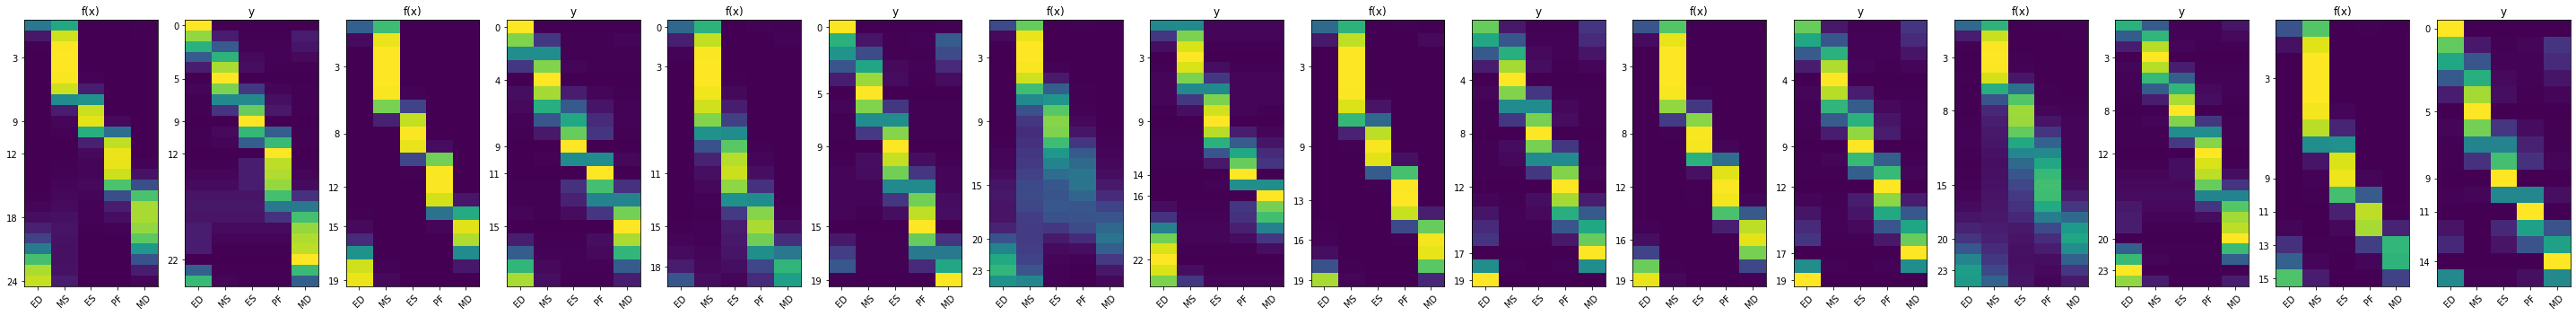

In [18]:
from src.visualization.Visualize import show_phases
_ = show_phases(outputs,pred)

In [21]:
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
score_fn(outputs, pred).numpy()

(8, 5)
(8,)


array([7., 4., 5., 6., 4., 3., 3., 4.], dtype=float32)

(8, 36, 5)
(5, 36, 8)


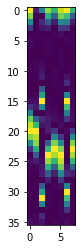

In [13]:
temp = outputs[:,0,...]
print(temp.shape)
print(temp.T.shape)
plt.imshow(temp.T[0])

In [25]:
# calculate the meandiff score for all batches
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
scores = []
for batch in validation_generator:
    x,y = batch
    p = model(x)
    scores.append(score_fn(y,p))
scores

[<tf.Tensor: shape=(), dtype=float32, numpy=4.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.75>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.625>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.75>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.875>]

In [26]:
tf.reduce_mean(scores).numpy()

5.125

# Generator tests

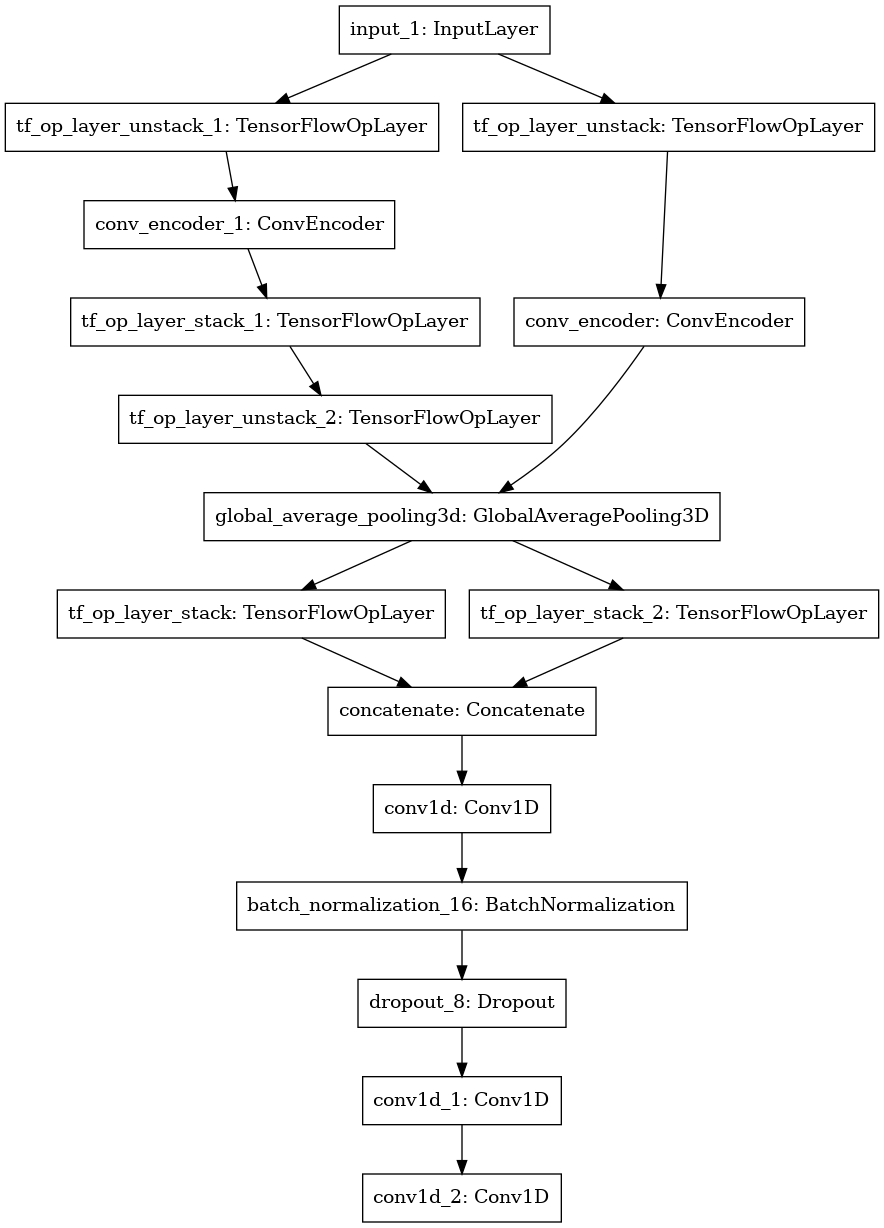

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [19]:
score_fn = meandiff_
score_fn(outputs, pred).numpy()

1.75

In [18]:
def meandiff_( y_true, y_pred, batchsize=4):

    """
    Average over the batches
    the sum of the absolute difference between two arrays
    y_true and y_pred are one-hot vectors with the following shape
    batchsize * timesteps * phase classes
    e.g.: 4 * 36 * 5
    First for gt and pred:
    - get the timesteps per phase with the highest probability
    - get the absolute difference between gt and pred
    (- later we can slice each patient by the max value in the corresponding gt indices)
    - sum the diff per entity
    - calc the mean over all examples

    Parameters
    ----------
    y_true :
    y_pred :

    Returns tf.float32 scalar
    -------

    """

    score = 0
    y_true = tf.cast(tf.convert_to_tensor(y_true), tf.float32)
    y_pred = tf.cast(tf.convert_to_tensor(y_pred), tf.float32)

    gt_idxs = tf.math.argmax(y_true, axis=1)
    gt_max = tf.cast(tf.reduce_max(gt_idxs, axis=1), tf.int32)
    padded_pred = []
    padded_gt = []

    msk = tf.stack([
        tf.pad(tf.ones((gt_max[i],5)), ((0,36-gt_max[i]),(0,0)))
        for i in range(batchsize)])
    #msk = tf.zeros_like(y_pred)
    #msk[:,:tf.reduce_max(gt_max), :] = 1

    temp_pred = y_pred * msk
    temp_gt = y_true * msk

    #y_pred = tf.unstack(y_pred, axis=0)
    #y_true = tf.unstack(y_true, axis=0)

    """def pad_to_size(p, max_id):
        to_pad = p.shape[0] - max_id
        print(p.shape[0])
        print(max_id)
        print(to_pad)
        return tf.pad(p, [[0,to_pad],[0,0]])

    padded_pred = list(map(lambda x : pad_to_size(x[0], x[1]), zip(y_pred, gt_max)))
    padded_gt = list(map(lambda x: pad_to_size(x[0], x[1]), zip(y_true, gt_max)))"""

    """for idx in tf.range(y_pred.shape[0]):
        max_idx = gt_max[idx]
        p = y_pred[idx][:max_idx, :]
        to_pad = y_pred.shape[1] - max_idx
        padded_pred.append(tf.pad(p, [[0,to_pad],[0,0]]))

        y = y_true[idx][:max_idx, :]
        padded_gt.append(tf.pad(y, [[0, to_pad], [0, 0]]))"""

    #temp_pred = tf.stack(padded_pred, axis=0)
    #temp_gt = tf.stack(padded_gt, axis=0)

    gt_idx = tf.math.argmax(temp_gt, axis=1)
    pred_idx = tf.math.argmax(temp_pred, axis=1)

    diffs = tf.stack([tf.stack(get_min_dist_for_list(gt_idx[i],pred_idx[i], batchsize)) for i in range(batchsize)])

    #diffs = tf.math.subtract(gt_idx, pred_idx)
    #print('substract: {}'.format(diffs.numpy()))
    #diffs = tf.abs(diffs)
    #print('abs: {}'.format(diffs.numpy()))
    diffs = tf.cast(tf.reduce_sum(diffs, axis=1),tf.float32)
    #print('sum: {}'.format(diffs.numpy()))
    diffs = tf.reduce_mean(diffs)

    return diffs


def get_min_dist_for_list(lst_a,lst_b, batchsize):
    length = tf.reduce_max(tf.stack([lst_a, lst_b]))
    #print(length)
    #length = max(max(lst_a), max(lst_b)) + 1
    return [get_min_distance(lst_a[i],lst_b[i],length) for i in range(batchsize)]

def get_min_distance(a, b, mod):
    #assert(mod>(tf.reduce_max(a,b))), 'a: {}, b: {}, mod:{}, '.format(a,b,mod)

    decr_counter = 0
    incr_counter = 0

    smaller = tf.reduce_min(tf.stack([a, b]))
    bigger = tf.reduce_max(tf.stack([a, b]))

    i1 = bigger
    while (i1 != smaller):
        decr_counter = decr_counter + 1
        i1 = i1 - 1

    i1 = bigger
    while (i1 != smaller):
        incr_counter = incr_counter + 1
        i1 = tf.math.mod((i1 + 1), mod)
        #i1 =  % mod

    return tf.reduce_min(tf.stack([decr_counter, incr_counter]))

In [22]:
lst = [1,2,3,4,5,6,7,8,9]
first = lst[3:]
first.extend(lst[:3])
first

[4, 5, 6, 7, 8, 9, 1, 2, 3]

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)